In [35]:
!pip install -U pygame

In [36]:
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time 
import os, sys
os.environ["SDL_VIDEODRIVER"] = "dummy"
import numpy as np
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
import pygame


In [37]:
pygame.init()

(4, 1)

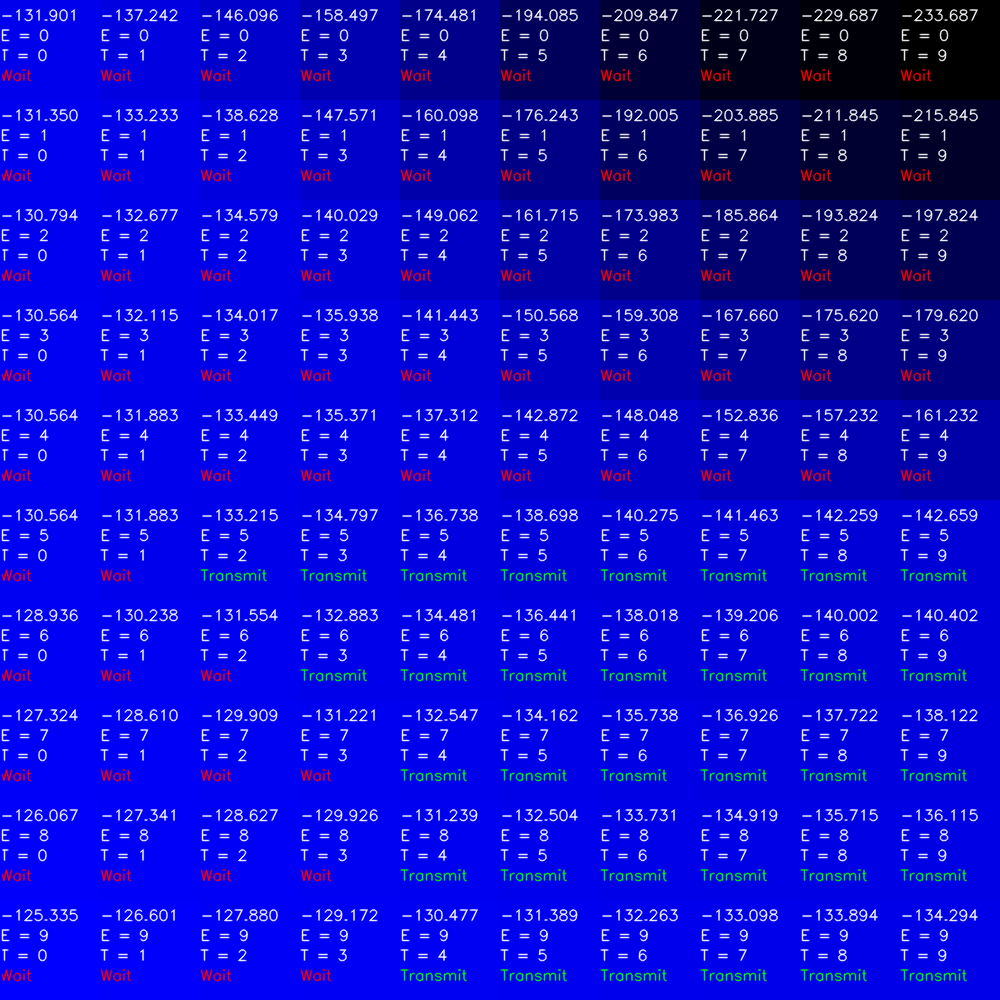

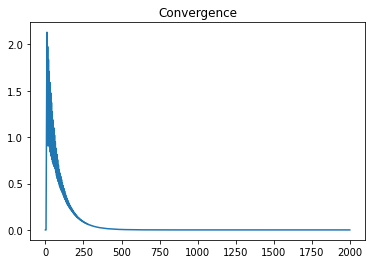

[[-131.90089266 -131.35007441 -130.79369233 -130.56387833 -130.56387833
  -130.56387833 -128.93582616 -127.32405451 -126.06728235 -125.33543094]
 [-137.2421888  -133.23322491 -132.67684284 -132.11484074 -131.88270539
  -131.88270539 -130.23820824 -128.61015607 -127.34068924 -126.6014454 ]
 [-146.09558305 -138.62847353 -134.57901506 -134.01701297 -133.44933408
  -133.21485392 -131.5537457  -129.90924856 -128.62695883 -127.88024788]
 [-158.49655117 -147.57129601 -140.02876114 -135.93839905 -135.37072017
  -134.79730715 -132.88257141 -131.22146319 -129.92622104 -129.17196755]
 [-174.48092723 -160.09752644 -149.06191517 -141.44319307 -137.31151419
  -136.73810118 -134.48100902 -132.54693251 -131.23860711 -130.4767349 ]
 [-194.08490727 -176.24336084 -161.71467317 -150.56759108 -142.87191219
  -138.69849918 -136.44140702 -134.16151595 -132.50388291 -131.3891747 ]
 [-209.84650327 -192.00495684 -173.98319277 -159.30775068 -148.04807179
  -140.27465878 -138.01756662 -135.73767555 -133.73073487 

In [38]:
number_of_iterations = 2000
MAX_SILENT_TIME = 10
SILENT_THRESHOLD = 5
BATTERY_SIZE = 10
DISCHARGE = 5
MINIMAL_CHARGE = 5
CHARGE = 1
GAMMA = 0.99
P_LOSS = 0.1

state_time = range(MAX_SILENT_TIME)
reward_1 = np.append(np.zeros(SILENT_THRESHOLD-1),-1*np.linspace(0, 4*(MAX_SILENT_TIME  - SILENT_THRESHOLD), MAX_SILENT_TIME  - SILENT_THRESHOLD+1))
print(reward_1)

plt.plot(reward_1)
plt.title('r_1')
plt.show()

state_energy = range(BATTERY_SIZE)
state_space_size = [len(state_time),len(state_energy)]

value = np.zeros(state_space_size)
pi = np.zeros(state_space_size)

#Screen size of state space value/policy image
screen = pygame.display.set_mode((MAX_SILENT_TIME*100, BATTERY_SIZE*100))

def value_iteration():
  for i in state_time:
    for j in state_energy:
      #print(i,j)
      if state_energy[j] < MINIMAL_CHARGE: #Not enough charge, can't transmit
        value[i,j] = reward_1[min(i, MAX_SILENT_TIME-1)] + GAMMA*value[min(i+1, MAX_SILENT_TIME-1),j+CHARGE] 
      elif state_energy[j]> BATTERY_SIZE-DISCHARGE-1: #Transmit and discharge for collision or sucsess, or don't transmit while battery full
        value[i,j] = max(((1-P_LOSS)*(reward_1[0] + GAMMA*value[0,j-DISCHARGE])+P_LOSS*(reward_1[i] + GAMMA*value[min(i+1, MAX_SILENT_TIME-1),j-DISCHARGE])),(reward_1[min(i+1, MAX_SILENT_TIME-1)] + GAMMA * value[min(i+1, MAX_SILENT_TIME-1),j])) #max(transmit good + transmit bad, wait)
      else: #Transmit and discharge for collision or sucsess, or don't transmit and charge
        value[i,j] = max(((1-P_LOSS)*(reward_1[0] + GAMMA*value[0,j-DISCHARGE])+P_LOSS*(reward_1[i] + GAMMA*value[min(i+1, MAX_SILENT_TIME-1),j-DISCHARGE])),(reward_1[min(i+1, MAX_SILENT_TIME-1)]* + GAMMA * value[min(i+1, MAX_SILENT_TIME-1),j+CHARGE])) #max(transmit good + transmit bad, wait)

def get_policy():
  for i in state_time:
    for j in state_energy:
      #print(i,j)
      if state_energy[j] < MINIMAL_CHARGE: #Not enough charge, can't transmit
        pi[i,j] = 1
      elif state_energy[j]> BATTERY_SIZE-DISCHARGE-1: #Transmit and discharge for collision or sucsess, or don't transmit and charge
        pi[i,j] =  np.argmax([(((1-P_LOSS)*(reward_1[0] + GAMMA*value[0,j-DISCHARGE])+P_LOSS*(reward_1[i] + GAMMA*value[min(i+1, MAX_SILENT_TIME-1),j-DISCHARGE])),(reward_1[min(i+1, MAX_SILENT_TIME-1)] + GAMMA * value[min(i+1, MAX_SILENT_TIME-1),j]))])
      else: #Reset 
        pi[i,j] =  np.argmax([(((1-P_LOSS)*(reward_1[0] + GAMMA*value[0,j-DISCHARGE])+P_LOSS*(reward_1[i] + GAMMA*value[min(i+1, MAX_SILENT_TIME-1),j-DISCHARGE])),(reward_1[min(i+1, MAX_SILENT_TIME-1)]* + GAMMA * value[min(i+1, MAX_SILENT_TIME-1),j+CHARGE]))])
change = []      
for iter in range(number_of_iterations):
  old_v = value[0,0]
  value_iteration()
  new_v = value[0,0]
  delta = np.abs(old_v - new_v)
  change.append(delta)
  if iter%100 == 0:
    
    output.clear()
    posetiv_shift = value.min()
    Nor = np.abs(value- posetiv_shift).max()
    for i in state_time:
      for j in state_energy:
        
        if value.any() == 0:
          color = (0, 0, 0)
        else:
          color = (0, 0, int(value[i,j]- posetiv_shift)*(255/Nor))
          #print(color, Nor, int(np.abs(value[i,j])))  
        pygame.draw.rect(screen, color, pygame.Rect(i*100, j*100, 100, 100))
    pygame.display.flip()

    #convert image so it can be displayed in OpenCV
    view = pygame.surfarray.array3d(screen)

    #  convert from (width, height, channel) to (height, width, channel)
    view = view.transpose([1, 0, 2])

    #  convert from rgb to bgr
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
  
    for i in state_time:
          for j in state_energy:
            # Using cv2.putText() method
            img_bgr = cv2.putText(img_bgr, "E = %d" % j, (i*100,j*100+40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            img_bgr = cv2.putText(img_bgr, "T = %d" % i, (i*100,j*100+60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

            img_bgr = cv2.putText(img_bgr, "%.3f" % value[i,j], (i*100,j*100+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    #Display image, clear cell every 0.5 seconds
    cv2_imshow(img_bgr)
    #time.sleep(0.1)
get_policy()
output.clear()
for i in state_time:
  for j in state_energy:
    if pi[i,j] == 0:
      img_bgr = cv2.putText(img_bgr, "Transmit", (i*100,j*100+80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
    else:
      img_bgr = cv2.putText(img_bgr, "Wait", (i*100,j*100+80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
cv2_imshow(img_bgr)

plt.plot(range(len(change)),change)
plt.title('Convergence')
plt.show()
print(value)
print(pi)
